### method analysis for the proposed method
the script is similar to the notebook/3_swot_pixc_proc.ipynb

In [ ]:
import os
import pickle 
import numpy as np
import xarray as xr
from glob import glob
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
from rasterio.plot import show
import matplotlib.pyplot as plt
from utils.swot_utils import IQR_filter
from utils.date_transform import date_to_decimal
from utils.add_scale_bar import add_scale_bar
from utils.add_north_arrow import add_north_arrow
import warnings
warnings.filterwarnings("ignore", category=UserWarning, append=True)


In [19]:
### Lakes: take erhai as example
lake_name = 'yilong'
dir_pixc = 'data/swot_l2/pixc/'+ lake_name +'-lake'
path_lake_vec = 'data/lakes-vec/'+lake_name+'_s2_20240415.gpkg'
# path_lake_img = 'data/rsimg/'+lake_name+'_s2_20240415_wgs84.tif'
# path_lake_img = 'data/rsimg/dianchi_fuxian_yangzonghai_xingyun_s2_20240415_wgs84.tif'
path_lake_img = 'data/rsimg/qilu_yilong_s2_20240415_wgs84.tif'


#### (1) swot pixc data reading and checking

In [20]:
## Check original _readout.nc raster file.
paths_file = [os.path.join(dir_pixc, file) for file in os.listdir(dir_pixc) if 'readout' in file and '.nc' in file]
paths_file = sorted(paths_file, key=lambda x: x.split('/')[-1].split('_')[-5])
print(len(paths_file))
id = 6
print(paths_file[id])
## read one pixc data 
pixc_nc = xr.open_dataset(paths_file[id])
pixc_nc


102
data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_396_113R_20230915T020415_20230915T020426_PGC0_01_readout.nc


<xarray.Dataset>
Dimensions:           (points: 114464)
Coordinates:
    latitude          (points) float64 ...
    longitude         (points) float64 ...
Dimensions without coordinates: points
Data variables:
    height            (points) float32 ...
    solid_earth_tide  (points) float32 ...
    pole_tide         (points) float32 ...
    load_tide_fes     (points) float32 ...
    iono_cor_gim_ka   (points) float32 ...
    geoid             (points) float32 ...
    pixel_area        (points) float32 ...
    geolocation_qual  (points) float64 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3282
    interferogram_size_range:    5078
    looks_to_efflooks:           1.5528710624427353
    num_azimuth_looks:           7.0
    azimuth_offset:              4

In [21]:
## auxiliary data
lake_gpd = gpd.read_file(path_lake_vec).to_crs(4326)
## rsimg read
src_2lakes_img = rio.open(path_lake_img)
# rsimg_left, rsimg_right, rsimg_top, rsimg_bottom = src_2lakes_img.bounds.left, src_2lakes_img.bounds.right, src_2lakes_img.bounds.top, src_2lakes_img.bounds.bottom
lake_left, lake_right,lake_bottom, lake_top = lake_gpd.total_bounds[0], lake_gpd.total_bounds[2], lake_gpd.total_bounds[1], lake_gpd.total_bounds[3]


In [22]:
def height_cor(pixc_nc):
    """geophysical corrections for the height data.
       ! no inverse barometric correction.
    """
    height = pixc_nc.height.values
    solid_tide = pixc_nc.solid_earth_tide.values
    pole_tide = pixc_nc.pole_tide.values
    load_tide = pixc_nc.load_tide_fes.values
    iono_corr = pixc_nc.iono_cor_gim_ka.values  ## LakeSP product not have this correction.
    return height - (solid_tide + pole_tide + load_tide + iono_corr)    

### area weighted average heights
def area_averaged(heights, areas):
  pixel_heights_sum = np.sum(areas*heights)
  pixel_AreaWeighted_height = pixel_heights_sum/np.sum(areas)
  weighted_var = [(heights[i] - pixel_AreaWeighted_height)**2*areas[i] for i in range(heights.shape[0])]
  weighted_var_sum = np.sum(weighted_var)
  weighted_std = np.sqrt(weighted_var_sum/sum(areas))
  return pixel_AreaWeighted_height, weighted_std

### area weighted average heights
def simple_averaged(heights):
  pixel_heights_mean = np.mean(heights)
  pixel_heights_std = np.std(heights)
  return pixel_heights_mean, pixel_heights_std


In [103]:
## get acquisition time 
dates_data = [path.split('_')[-4] for path in paths_file]
dates_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8]+'T'+date[9:11]+':'+date[11:13]+':'+date[13:15]
              for date in dates_data]
## convert date to decimal
dates_decimal = [date_to_decimal(date) for date in dates_data]
dates_decimal = [round(date, 5) for date in dates_decimal]
dates_decimal[11]


2023.81867

#### (2) Check the outlier removing of pixel cloud data by using IQR method.


In [24]:
# i=9; path_file = paths_file[i]  ## lugu 
i=30; path_file = paths_file[i]  ## yilong
print(i, path_file)
date_decimal = dates_decimal[i]

30 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_008_396_113R_20231228T094938_20231228T094949_PGC0_01_readout.nc


In [25]:
## (1) data reading
pixc_nc = xr.open_dataset(path_file)
## (2) geophysical corrections and convert to egm2008 height.
heights_cor = height_cor(pixc_nc=pixc_nc)
heights_cor =  heights_cor - pixc_nc.geoid.values  ## to egm2008 height  
## (3) outliers removing using IQR method.
heights_cor_IQR, IQR = IQR_filter(heights_cor)
iter = 0
while IQR > 0.6:    
    iter += 1
    heights_cor_IQR_mask = heights_cor_IQR.mask
    heights_cor_IQR, IQR = IQR_filter(heights_cor_IQR.filled(np.nan))
    heights_cor_IQR.mask = heights_cor_IQR.mask | heights_cor_IQR_mask
    if iter == 2: break    ## max iteration: 4 times.
print(IQR)


0.465576171875


color range:  [1410.8, 1412.6]


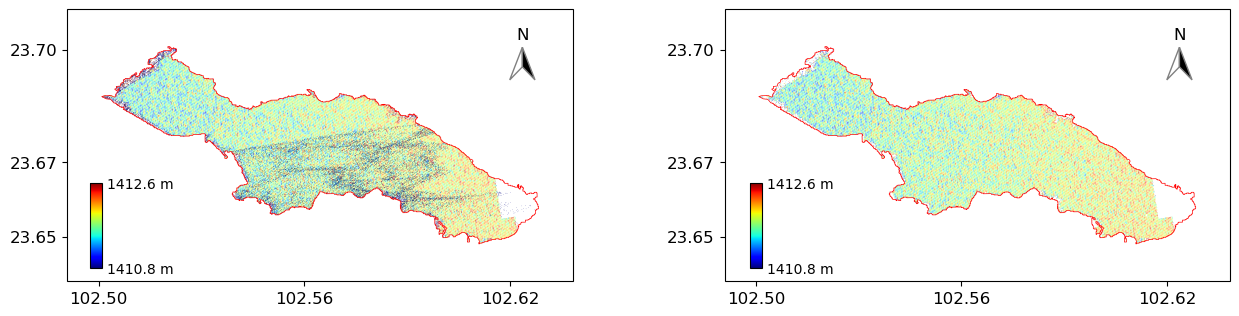

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace=0.3)
xticks = np.linspace(lake_gpd.total_bounds[0], lake_gpd.total_bounds[2]-0.01, 3)
xticks = [ round(x, 2) for x in list(xticks)]; 
yticks = np.linspace(lake_gpd.total_bounds[1], lake_gpd.total_bounds[3], 3)
yticks = [ round(y, 2) for y in list(yticks)]
color_range = [round(heights_cor_IQR.min(), 1), round(heights_cor_IQR.max(), 1)]  ## erhai
## (1) heights before IQR method
ax[0].set_extent([lake_left-0.01, lake_right+0.01, lake_bottom-0.01, lake_top+0.01])
# show(src_2lakes_img, indexes=(3,2,1), percent_range=[5, 95], ax=ax[0], title=lake_name)
scat1 = ax[0].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=heights_cor,
            s=0.1, edgecolor='none', cmap='jet')
lake_gpd.plot(ax=ax[0], edgecolor='red', facecolor='none', linewidth=0.5)
add_scale_bar(ax=ax[0], length=4, location=(0.2, 0.04), linewidth=3, color_bar='white', color_text='white')
add_north_arrow(ax=ax[0], location=(0.9, 0.8), size_height=0.06)
ax[0].set_xticks(xticks); ax[0].set_yticks(yticks)
ax[0].tick_params(axis='both', which='major', labelsize=12)
scat1.set_clim(vmin=color_range[0], vmax=color_range[1])
cbar_ax = fig.add_axes([0.14, 0.25, 0.008, 0.17])
cbar = plt.colorbar(scat1, ax=ax[0], cax=cbar_ax)
cbar.ax.tick_params(length=0)
cbar.set_ticks(color_range); cbar.set_ticklabels([str(color_range[0])+' m', str(color_range[1])+' m'])

# ## (2) heights after IQR method
ax[1].set_extent([lake_left-0.01, lake_right+0.01, lake_bottom-0.01, lake_top+0.01])
# show(src_2lakes_img, indexes=(3,2,1), percent_range=[5, 95], ax=ax[1], title=lake_name)
scat2 = ax[1].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=heights_cor_IQR,
            s=0.1, edgecolor='none', cmap='jet')
lake_gpd.plot(ax=ax[1], edgecolor='red', facecolor='none', linewidth=0.5)
add_scale_bar(ax=ax[1], length=4, location=(0.2, 0.04), linewidth=3, color_bar='white', color_text='white')
add_north_arrow(ax=ax[1], location=(0.9, 0.8), size_height=0.06)
ax[1].set_xticks(xticks); ax[1].set_yticks(yticks)
ax[1].tick_params(axis='both', which='major', labelsize=12)
scat2.set_clim(vmin=color_range[0], vmax=color_range[1])
print('color range: ',color_range)
cbar_ax = fig.add_axes([0.58, 0.25, 0.008, 0.17])
cbar = plt.colorbar(scat2, ax=ax[1], cax=cbar_ax)
cbar.ax.tick_params(length=0)
cbar.set_ticks(color_range); cbar.set_ticklabels([str(color_range[0])+' m', str(color_range[1])+' m'])


#### (3) time-series lake level retrieval

In [105]:
heights_lake_mean, heights_lake_std = {}, {}
# heights_lake_mean_sim, heights_lake_std_sim = {}, {}
for i, path in enumerate(paths_file):
  ## set i for the results of average and weighted average methods
  # i=7; path = paths_file[i]  ## erhai: set the specific file. 7,8,22,23,28,42,52,53,54,55,65,70,71,
  # i=9; path = paths_file[i]  ## dianchi: 2,5,7,9,10,23,28,34,59,63
  # i=30; path = paths_file[i]  ## yilong
  print(i, path)
  date_decimal = dates_decimal[i]
  ## (1) data reading
  pixc_nc = xr.open_dataset(path)
  ## (2) geophysical corrections and convert to egm2008 height.
  heights_cor = height_cor(pixc_nc=pixc_nc)
  heights_cor =  heights_cor - pixc_nc.geoid.values  ## to egm2008 height  
  ## (3) outliers removing using IQR method.
  iter = 0
  heights_cor_IQR, IQR = IQR_filter(heights_cor)
  while IQR > 0.6:    
      iter += 1
      heights_cor_IQR_mask = heights_cor_IQR.mask
      heights_cor_IQR, IQR = IQR_filter(heights_cor_IQR.filled(np.nan))
      heights_cor_IQR.mask = heights_cor_IQR.mask | heights_cor_IQR_mask
      if iter == 2: break   ## max iteration: 4 times.
  if IQR > 0.6: continue
  if (~heights_cor_IQR.mask).sum() < 100: continue  ## the threshold of the number of valid measurements. 
  ## (4) lake level calculation (area weighted average and std of the heights).
  pixel_area = pixc_nc.pixel_area.values
  pixel_heights_ = heights_cor_IQR[~heights_cor_IQR.mask]
  pixel_area_ = pixel_area[~heights_cor_IQR.mask]
  # area-averaged lake level
  pixels_height, pixels_std = area_averaged(heights=pixel_heights_, areas=pixel_area_)
  heights_lake_mean[date_decimal] = pixels_height
  heights_lake_std[date_decimal] = pixels_std
  ## simple-averaged lake level
  # pixels_height_sim, pixels_std_sim = simple_averaged(heights=pixel_heights_)
  # heights_lake_mean_sim[date_decimal] = pixels_height_sim
  # heights_lake_std_sim[date_decimal] = pixels_std_sim
  # break


0 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_553_023_196L_20230616T045819_20230616T045830_PGC0_01_readout.nc
1 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_001_396_113R_20230804T083404_20230804T083415_PGC0_01_readout.nc
2 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_002_396_113R_20230825T051908_20230825T051919_PGC0_01_readout.nc
3 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_049_196L_20230902T164600_20230902T164611_PGC0_01_readout.nc
4 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_049_196R_20230902T164600_20230902T164611_PGC0_01_readout.nc
5 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_118_113L_20230905T034158_20230905T034209_PGC0_01_readout.nc
6 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_003_396_113R_20230915T020415_20230915T020426_PGC0_01_readout.nc
7 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_004_396_113R_20231005T224916_20231005T224927_PGC0_01_readout.nc
8 data/swot_l2/pixc/yilong-lake/SWOT_L2_HR_PIXC_005_049_196L_20231014T101607_20231014T101619_PGC0_01_rea

#### (4) time-series data processing      
select yilong lake for checking

In [106]:
heights_lake_mean_filtered = heights_lake_mean.copy()
heights_lake_std_filtered = heights_lake_std.copy()
heights = list(heights_lake_mean.values())
dates = list(heights_lake_mean.keys())
# heights_lake_mean_sim_filtered = heights_lake_mean_sim.copy()
# heights_lake_std_sim_filtered = heights_lake_std_sim.copy()
# heights = list(heights_lake_mean_sim.values())
# dates = list(heights_lake_mean_sim.keys())

for i, date in enumerate(dates):
    ### define the temporal window to one year.
    date_decimal_min, date_decimal_max = date-0.5, date+0.5
    id_win = np.where((np.array(dates) >= date_decimal_min) \
                      & (np.array(dates) < date_decimal_max))[0].tolist()
    id_win.remove(i)     ## delete the lake level of the current date.
    heights_win = [heights[j] for j in id_win]
    mean_height_year, std_height_year = np.mean(heights_win), np.std(heights_win)
    max_height_year = mean_height_year + 3*std_height_year
    min_height_year = mean_height_year - 3*std_height_year
    if heights[i] > max_height_year or heights[i] < min_height_year:
        heights_lake_mean_filtered.pop(date)
        heights_lake_std_filtered.pop(date)
        # heights_lake_mean_sim_filtered.pop(date)
        # heights_lake_std_sim_filtered.pop(date)


Text(0.5, 1.0, 'Lake level (m) in yilong Lake')

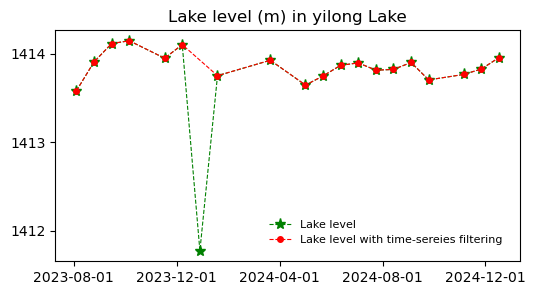

In [116]:
date_ticks = ['2023-08-01','2023-12-01', '2024-04-01', '2024-08-01', '2024-12-01']
dates_decimal = [date_to_decimal(date+'T00:00:00') for date in date_ticks]
fig, ax = plt.subplots(1,1,figsize=(6,3))
# plt.rcParams['font.size'] = 10
ax.plot(heights_lake_mean.keys(), 
        heights_lake_mean.values(), 
        '--*', linewidth=0.8, markersize=8,
            color='green', label='Lake level')
ax.plot(heights_lake_mean_filtered.keys(), 
        heights_lake_mean_filtered.values(), 
        '--.', linewidth=0.8, markersize=8,
        color='red', label='Lake level with time-sereies filtering')
# ax.fill_between(heights_lake_mean.keys(), 
#                 np.array([*heights_lake_mean.values()]) - np.array([*heights_lake_std.values()]),
#                 np.array([*heights_lake_mean.values()]) + np.array([*heights_lake_std.values()]),
#                 color='Brown', alpha=0.1)
# ax.set_ylim([1800, 2000])
# ax.set_xticks(np.arange())
ax.set_xticks(dates_decimal); ax.set_xticklabels(date_ticks, rotation=0)
ax.set_yticks([1412, 1413, 1414])
ax.legend(fontsize=8,loc=(0.45, 0.05), frameon=False)
ax.set_title('Lake level (m) in ' + lake_name + ' Lake')


In [15]:
# ## write numpy data in 
# path_save = 'data/swot_l2/pixc/'+ lake_name +'-lake/'+lake_name+'_heights_lake_mean_sim.pkl'
# with open(path_save, 'wb') as f:
#         pickle.dump(heights_lake_mean_sim_filtered, f)
